### import libraries

In [1]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model as linear_model

### datapath define

In [2]:
import os
datapath = os.path.join("../input/house-prices-advanced-regression-techniques/")


### import data

In [3]:
# oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=",");
# gdp_data =  pd.read_csv(datapath + "gdp_per_capita.csv", thousands=",", delimiter='\t', encoding='latin1', na_values="n/a");
housing = pd.read_csv(datapath + "train.csv");
testdf = pd.read_csv(datapath + "test.csv");
sampleSubmissiondf = pd.read_csv(datapath + "sample_submission.csv");

### load the data

In [4]:
pd.set_option('display.max_columns', None)  

print(housing.head())
print(housing.describe())
print(housing.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

### Build a quick Baseline

In [5]:
from sklearn.ensemble import RandomForestRegressor


# Create a copy to work with
X = housing.copy()

# Save and drop labels
y = housing.SalePrice
X = X.drop('SalePrice', axis=1)

# fill NANs
X = X.fillna(-999)

# Label Encoder
for c in housing.columns[housing.dtypes == 'object']:
  X[c] = X[c].factorize()[0]

rf = RandomForestRegressor()
rf.fit(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [6]:
rf.feature_importances_

array([4.79512662e-03, 1.57227451e-03, 4.63688307e-04, 5.51246308e-03,
       1.04536408e-02, 6.83037898e-06, 2.57216990e-04, 2.41288059e-03,
       3.52582505e-04, 0.00000000e+00, 1.63051430e-03, 8.43854711e-04,
       3.82254081e-03, 2.77304037e-03, 1.41157294e-05, 8.67818195e-05,
       3.55908972e-04, 5.70974888e-01, 4.06692349e-03, 8.53511746e-03,
       4.99244513e-03, 1.11788149e-03, 2.50483419e-04, 1.69134665e-03,
       1.57098402e-03, 2.01049536e-03, 2.56428954e-03, 6.96341735e-03,
       1.75754316e-04, 2.17801894e-04, 3.52534949e-03, 1.34098371e-04,
       3.91180147e-03, 1.98078020e-03, 2.51153115e-02, 1.31708514e-04,
       1.08299737e-03, 6.25422989e-03, 5.09631421e-02, 2.76669863e-05,
       6.26863000e-04, 3.42799577e-03, 2.99715645e-04, 2.64285131e-02,
       5.02788155e-02, 5.27227483e-05, 8.98417616e-02, 7.38554918e-04,
       1.12903641e-04, 1.26758577e-02, 3.54597158e-04, 2.37581735e-03,
       4.60814870e-04, 2.49703373e-03, 6.29675850e-03, 6.45386051e-04,
      

([<matplotlib.axis.XTick at 0x7fe478000438>,
 <a list of 80 Text xticklabel objects>)

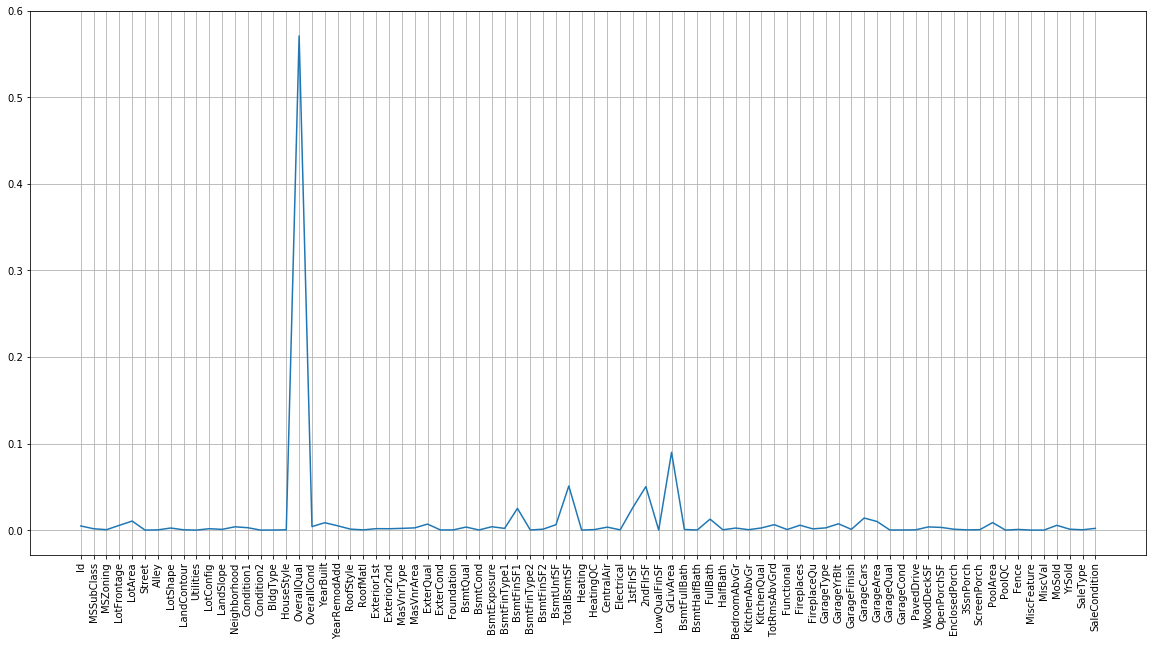

In [7]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns.tolist(), rotation=90)

### plot data

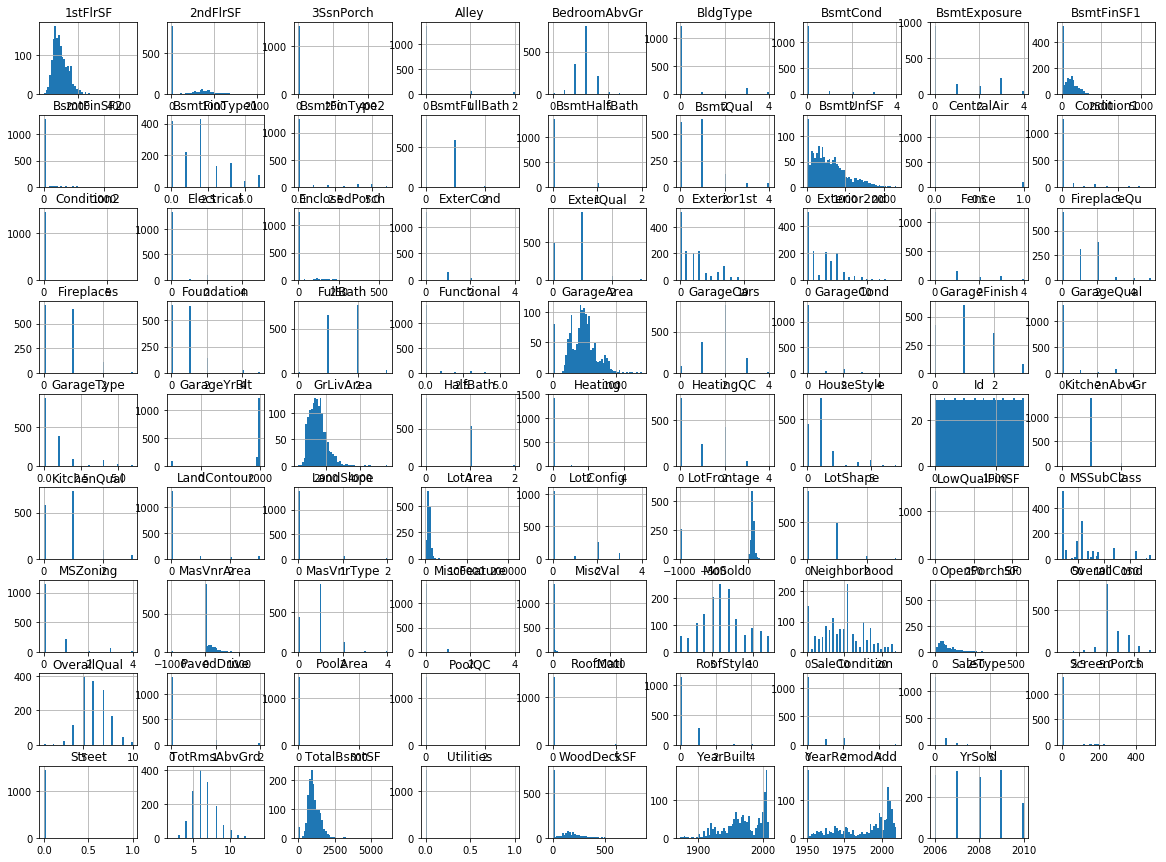

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
X.hist(bins=50, figsize=(20,15))
plt.show()

### Utitly to print variance and mean

In [9]:
def print_var(column_names_low, housing1):
  for column in column_names_low:
    columnSeriesObj = housing1[column]
    print(columnSeriesObj.value_counts())
    print(columnSeriesObj.count())
    if columnSeriesObj.dtype  !='object':
      print(columnSeriesObj.mean())
      print(columnSeriesObj.var())
    else:
      print("Type:",columnSeriesObj.dtype)
  

### explore some features


In [10]:
column_names_low = ["Functional", "Alley", "Fence", "ExterCond", "PoolQC","Utilities","MiscFeature","Id","SalePrice"]

column_names_high = ["OverallQual", "GrLivArea", "2ndFlrSF","1stFlrSF","TotalBsmtSF","BsmtFinSF1","MasVnrArea","YearBuilt","YearRemodAdd","Neighborhood","LotArea","LotFrontage" ]
print_var(column_names_high, housing)
print_var(column_names_high, testdf)


5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
1460
6.0993150684931505
1.9126794482991696
864     22
1040    14
894     11
848     10
1456    10
        ..
3447     1
1396     1
1395     1
1393     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64
1460
1515.463698630137
276129.63336259616
0       829
728      10
504       9
672       8
546       8
       ... 
788       1
1116      1
1112      1
1111      1
1872      1
Name: 2ndFlrSF, Length: 417, dtype: int64
1460
346.99246575342465
190557.0753373038
864     25
1040    16
912     14
848     12
894     12
        ..
1285     1
1287     1
1288     1
1297     1
2053     1
Name: 1stFlrSF, Length: 753, dtype: int64
1460
1162.626712328767
149450.07920371392
0       37
864     35
672     17
912     15
1040    14
        ..
1463     1
1459     1
1454     1
1019     1
2046     1
Name: TotalBsmtSF, Length: 721, dtype: int64
1460
1057.4294520547944
192462.3

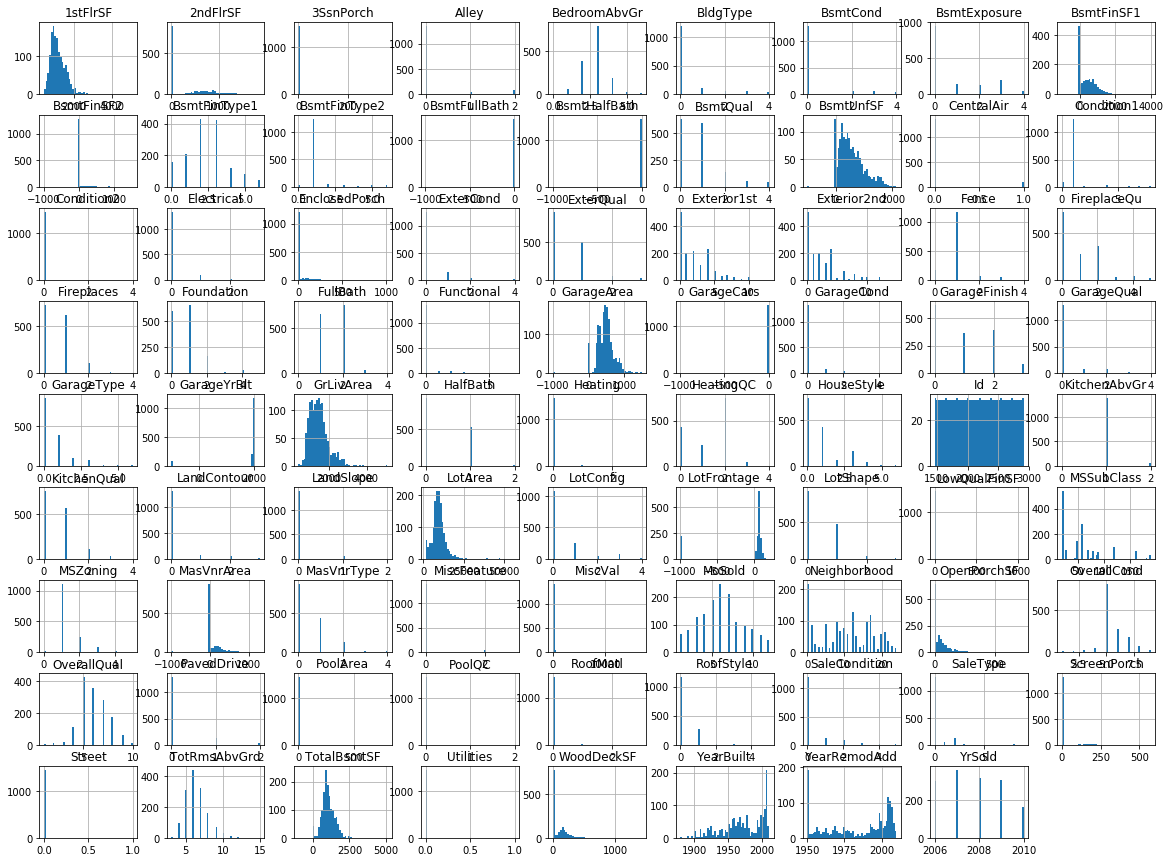

In [11]:
# explore test data
# fill NANs
test = testdf.fillna(-999)

# Label Encoder
for c in testdf.columns[testdf.dtypes == 'object']:
  test[c] = test[c].factorize()[0]

%matplotlib inline
import matplotlib.pyplot as plt
test.hist(bins=50, figsize=(20,15))
plt.show()

### explore if columns donot have variance

In [12]:
cols = test.select_dtypes([np.number]).columns
std = test[cols].std()
cols_to_drop = std[abs(std)<0.2].index
# print(cols_to_drop)
print_var(cols_to_drop, test)

0    1453
1       6
Name: Street, dtype: int64
1459
0.00411240575736806
0.004098302856965601
0    1457
1       2
Name: Utilities, dtype: int64
1459
0.0013708019191226869
0.0013698617257625425
0    1442
1      12
2       4
3       1
Name: RoofMatl, dtype: int64
1459
0.015764222069910898
0.025128547937169034
0    1446
1       9
3       2
2       2
Name: Heating, dtype: int64
1459
0.013022618231665525
0.023835782066939308
0    1456
1       2
2       1
Name: PoolQC, dtype: int64
1459
0.0027416038382453737
0.004107704790567216


#### Test random forest

In [13]:
from sklearn.model_selection import cross_val_score

scores_rf = cross_val_score(rf, X, y, scoring="neg_mean_squared_error", cv=10)
print(scores_rf)

[-6.72498376e+08 -8.74709796e+08 -6.40450576e+08 -1.51981137e+09
 -1.47720662e+09 -5.68036300e+08 -6.96568587e+08 -7.79446194e+08
 -1.72412297e+09 -9.23618816e+08]


### split the data into training and test

In [14]:
import numpy as np

np.random.seed(42)

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  print(shuffled_indices)
  print(test_indices)
  print(train_indices)
  return data.iloc[train_indices], data.iloc[test_indices]

### call data splitter

In [15]:
train_set, test_set = split_train_test(housing,0.2)
print(len(train_set), "train + ", len(test_set), "test")

[ 892 1105  413 ... 1294  860 1126]
[ 892 1105  413  522 1036  614  218 1160  649  887  576 1252 1061  567
 1108 1113  168 1102 1120   67 1040  453  670 1094  192  123  415  277
  433 1317  184  554 1173   76  906  674 1398  374 1032  259   51  244
 1101  581  679 1132 1220   49  591 1269 1249 1138  490 1024  811  141
  846  925  772  532   29 1299   65  765 1347  175  394  619 1131  115
  894 1221  427  736  898  682  990  718   44   59  363  398  422  494
  416  584  270  351 1078 1344  836  643  274  322   78  922  275 1265
  220  316 1006 1240   70   15 1164 1320  754  720 1047  628  636  464
  855 1397  382 1428  788 1340 1216  332  543  203 1134 1414  429 1272
  746  589  838 1293  590  585 1201  198  916  994 1228   43 1033  691
  231  526  101 1092  411 1392  907  782  952  620  669  128  529  910
  998 1450 1163  247  528  733   32  634 1027 1053  575  843  297  261
 1046  939  309  163 1009  599 1175  371  239  881 1333 1358 1156  812
 1331  425 1054   63  817 1394 1306  915 

#### scikit train test split

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Looking for correlations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe471f212e8>,
      dtype=object)

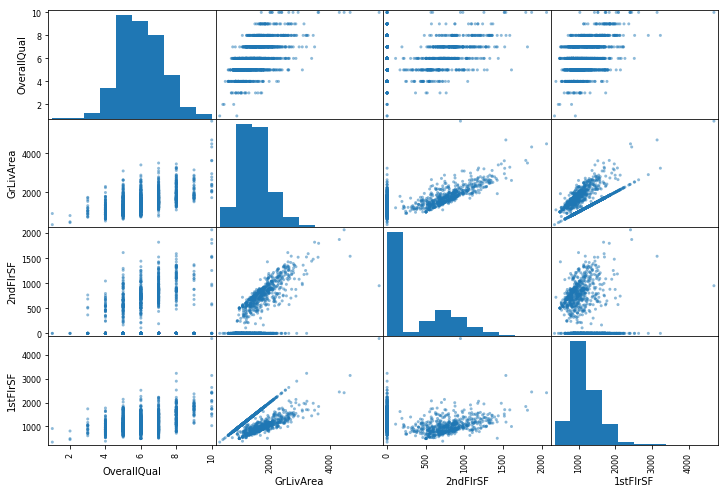

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["OverallQual", "GrLivArea", "2ndFlrSF", "1stFlrSF"]

scatter_matrix(housing[attributes], figsize=(12, 8))

In [18]:
corr_matrix = housing.corr()

### convert to clean training set

In [19]:

train_features = train_set.drop("SalePrice", axis=1)
train_labels = train_set["SalePrice"].copy()

test_features = test_set.drop("SalePrice", axis=1)
test_labels = test_set["SalePrice"].copy()

In [20]:
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


## Data Cleaning

### Transformation Pipelines

### DataFrameSelector class

In [21]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer 

class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    return X[self.attribute_names].values

### Custom One HotEncoder 

In [22]:
class CustomEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, n_values='auto'):
        self.n_values = n_values

    def transform(self, X):
        ohe = pd.get_dummies(list(X),  dummy_na=True)
        return ohe

    def fit(self, X, y=None):
        return self

Custom LabelBinarizer class

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


cat_features=list(set([i for i in train_features.columns if train_features.dtypes[i]=='object']) - set(column_names_low))
num_features = list(set(train_features._get_numeric_data().columns) - set(column_names_low))

# cat_features = ["Neighborhood"]



# num_features=['OverallQual',
#  'GrLivArea',
#  '2ndFlrSF',
#  '1stFlrSF',
#  'TotalBsmtSF',
#  'BsmtFinSF1',
#  'MasVnrArea','YearBuilt','YearRemodAdd','LotArea','LotFrontage']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer (strategy='median')),
    ('std_scaler', StandardScaler())
])

categorical_transformer = Pipeline([
     ('imputer', SimpleImputer (strategy='most_frequent')),
    ('labelBinarizer',OneHotEncoder(sparse=False,handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

fullpipeline = Pipeline([
    ("preprocessor",preprocessor),
])

   ### Random Hyperparameter Grid

In [24]:

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

### Random Search Training


In [25]:
train_features_transformed = fullpipeline.fit_transform(train_features)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features_transformed, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


# Select and Train the model

### Best Model

In [26]:
rf_random.best_estimator_
train_features_transformed = fullpipeline.fit_transform(train_features)


In [27]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features_transformed, train_labels)
test_features_transformed = fullpipeline.transform(test_features) 
base_accuracy = evaluate(base_model, test_features_transformed, test_labels)
               
               
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features_transformed, test_labels)
               
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 19206.4014 degrees.
Accuracy = 88.46%.
Model Performance
Average Error: 17178.8539 degrees.
Accuracy = 89.30%.
Improvement of 0.95%.


In [28]:
# rmse_rf = np.sqrt(-scores_rf)
# display_scores(rmse_rf)

# generate submission like sample submission

In [29]:
sampleSubmissiondf = pd.read_csv(datapath + "sample_submission.csv");
print(sampleSubmissiondf.head())
testdf = pd.read_csv(datapath + "test.csv");
testdf.head()


     Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [30]:
IDArr = testdf['Id'].values
clf = best_random
clf.fit(train_features_transformed, train_labels)
final_test_predictions = clf.predict(fullpipeline.transform(testdf))


#### generate CSV

In [31]:
df = pd.DataFrame({'Id':IDArr,'SalePrice': final_test_predictions})
# df.to_csv(index=False)

df.to_csv(r'results.csv',index=False)

In [32]:
df.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,179196.457149
std,421.321334,67852.232978
min,1461.000000,68795.000000
25%,1825.500000,132032.586250
50%,2190.000000,159331.132500
75%,2554.500000,208626.036250
max,2919.000000,475338.212500
